In [4]:
import os
os.chdir("..")

Load Libraries

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from SSTImportanceSampling  import Preprocessor, ImportanceSampler, StormDepthProcessor, AdaptParams, AdaptiveMixtureSampler

from production.metrics import get_error_stats
from production.plots import plot_adaptive_evolution

Preprocess data

In [ ]:
trinity = Preprocessor(config_path = "/workspaces/Importance-Sampling-for-SST/data/0_source/Trinity/config.json", 
                       output_folder = "/workspaces/Importance-Sampling-for-SST/data/1_interim/Trinity")
trinity.run()

In [6]:
trinity = Preprocessor.load(config_path = "/workspaces/Importance-Sampling-for-SST/data/1_interim/Trinity/config.json")

Full Monte Uniform Samples

In [16]:
sampler = ImportanceSampler(
    distribution="uniform",
    params = {},
    num_simulations=1_000_000,
    num_rep=1,
)

trinity_fullmonte_samples = sampler.sample(trinity.domain_gdf, trinity.watershed_gdf)

In [17]:
processor = StormDepthProcessor(
    precip_cube=trinity.cumulative_precip,
    storm_centers=trinity.storm_centers,
    watershed_gdf=trinity.watershed_gdf
)

trinity_fullmonte_depths = processor.shift_and_extract_precip(
    df_storms=trinity_fullmonte_samples,
    n_jobs=-1,    
    seed=42   
)

In [18]:
#Save
trinity_fullmonte_depths.to_parquet("/workspaces/Importance-Sampling-for-SST/data/1_interim/Trinity/trinity_fullmonte_depths.pq")

In [7]:
#Read
trinity_fullmonte_depths = pd.read_parquet("/workspaces/Importance-Sampling-for-SST/data/1_interim/Trinity/trinity_fullmonte_depths.pq")

Importance Sampling - Truncated Normals

In [8]:
#Sample
params = {
    "mu_x": trinity.watershed_stats["x"],  
    "mu_y": trinity.watershed_stats["y"],      
    "sd_x": trinity.watershed_stats["range_x"],
    "sd_y": trinity.watershed_stats["range_y"]*0.5,                            
}

sampler = ImportanceSampler(
    distribution="truncated_gaussian",
    params=params,
    num_simulations=350_000,
    num_rep=1,
    seed=42,
)

samples = sampler.sample(trinity.domain_gdf)

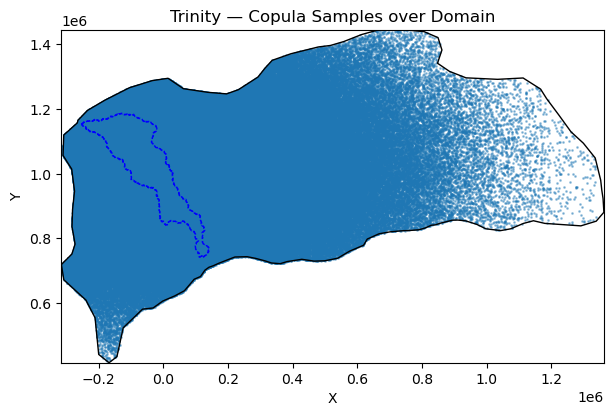

In [9]:
import matplotlib.pyplot as plt

# Plot domain and watershed boundaries
fig, ax = plt.subplots(figsize=(7,7))
trinity.domain_gdf.boundary.plot(ax=ax, edgecolor="black", linewidth=1)
trinity.watershed_gdf.boundary.plot(ax=ax, edgecolor="blue", linewidth=1, linestyle="--")

# Scatter all samples (x, y)
ax.scatter(
    samples["x"].to_numpy(),
    samples["y"].to_numpy(),
    s=1, alpha=0.4
)

# Nice axes and title
ax.set_aspect("equal", adjustable="box")
minx, miny, maxx, maxy = trinity.domain_gdf.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_title("Trinity — Copula Samples over Domain")
plt.show()

In [10]:
#Transpose
processor = StormDepthProcessor(
    precip_cube=trinity.cumulative_precip,
    storm_centers=trinity.storm_centers,
    watershed_gdf=trinity.watershed_gdf
)

trinity_gaussian_depths = processor.shift_and_extract_precip(
    df_storms=samples,
    n_jobs=-1,    
    seed=42   
)

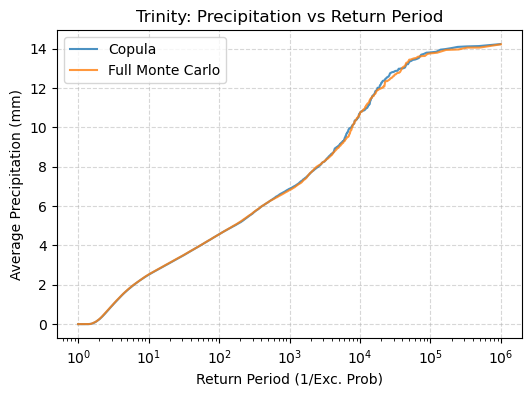

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(1/trinity_gaussian_depths["exc_prb"], trinity_gaussian_depths["precip_avg_mm"]/25.4, 
         label="Copula", alpha=0.8)
plt.plot(1/trinity_fullmonte_depths["exc_prb"], trinity_fullmonte_depths["precip_avg_mm"]/25.4, 
         label="Full Monte Carlo", alpha=0.8)

plt.xscale("log")  # log scale for return period
plt.xlabel("Return Period (1/Exc. Prob)")
plt.ylabel("Average Precipitation (mm)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.title("Trinity: Precipitation vs Return Period")
plt.show()

In [12]:
get_error_stats(trinity_gaussian_depths,trinity_fullmonte_depths,pcol="exc_prb", ycol="precip_avg_mm", to_inches=True)

{'rmse': 0.07358964184733646, 'diff_at_max': 0.009600114041223407}

Importance Sampling - Gaussian Copula

In [10]:
#Sample
params = {
    "mu_x": trinity.watershed_stats["x"],  
    "mu_y": trinity.watershed_stats["y"],      
    "sd_x": trinity.watershed_stats["range_x"],
    "sd_y": trinity.watershed_stats["range_y"]*0.5, 
    "rho": -0.2,                                
}

sampler = ImportanceSampler(
    distribution="gaussian_copula",
    params=params,
    num_simulations=300_000,
    num_rep=1,
    seed=42,
)

samples = sampler.sample(trinity.domain_gdf)

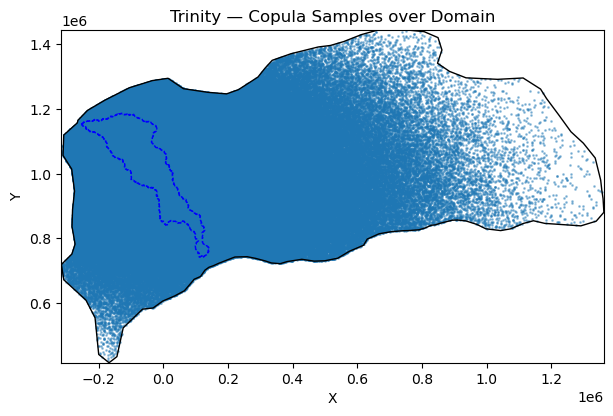

In [11]:
import matplotlib.pyplot as plt

# Plot domain and watershed boundaries
fig, ax = plt.subplots(figsize=(7,7))
trinity.domain_gdf.boundary.plot(ax=ax, edgecolor="black", linewidth=1)
trinity.watershed_gdf.boundary.plot(ax=ax, edgecolor="blue", linewidth=1, linestyle="--")

# Scatter all samples (x, y)
ax.scatter(
    samples["x"].to_numpy(),
    samples["y"].to_numpy(),
    s=1, alpha=0.4
)

# Nice axes and title
ax.set_aspect("equal", adjustable="box")
minx, miny, maxx, maxy = trinity.domain_gdf.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_title("Trinity — Copula Samples over Domain")
plt.show()


In [ ]:
#Transpose
processor = StormDepthProcessor(
    precip_cube=trinity.cumulative_precip,
    storm_centers=trinity.storm_centers,
    watershed_gdf=trinity.watershed_gdf
)

trinity_copula_depths = processor.shift_and_extract_precip(
    df_storms=samples,
    n_jobs=-1,    
    seed=42   
)

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(1/trinity_copula_depths["exc_prb"], trinity_copula_depths["precip_avg_mm"]/25.4, 
         label="Copula", alpha=0.8)
plt.plot(1/trinity_fullmonte_depths["exc_prb"], trinity_fullmonte_depths["precip_avg_mm"]/25.4, 
         label="Full Monte Carlo", alpha=0.8)

plt.xscale("log")  # log scale for return period
plt.xlabel("1/Exc. Prob")
plt.ylabel("Average Precipitation (mm)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.title("Trinity: Precipitation vs Return Period")
plt.show()

In [31]:
get_error_stats(trinity_copula_depths,trinity_fullmonte_depths,pcol="exc_prb", ycol="precip_avg_mm", to_inches=True)

{'rmse': 0.12812811981476055, 'diff_at_max': 0.02024639980838927}

Mixture of two normals

In [67]:
#Sample
params = {
    "mu_x_narrow": trinity.watershed_stats["x"],  
    "mu_y_narrow": trinity.watershed_stats["y"],
    "mu_x_wide": trinity.domain_stats["x"],  
    "mu_y_wide": trinity.domain_stats["y"],
    "sd_x_narrow": trinity.watershed_stats["range_x"]*0.3,
    "sd_y_narrow": trinity.watershed_stats["range_y"]*0.3,
    "sd_x_wide": trinity.domain_stats["range_x"],
    "sd_y_wide": trinity.domain_stats["range_y"],
    "mix": 0.8,
    "rho_narrow": -0.7,
    "rho_wide":   0.1,
}

sampler = ImportanceSampler(
    distribution="mixture_trunc_gauss",
    params=params,
    num_simulations=100_000,
    num_rep=1,
    seed=42,
)

samples = sampler.sample(trinity.domain_gdf)

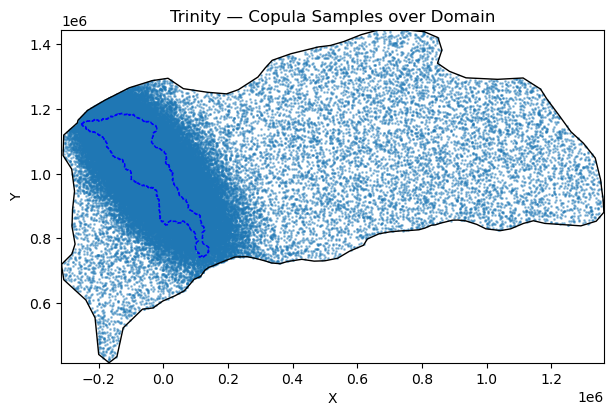

In [ ]:
import matplotlib.pyplot as plt

# Plot domain and watershed boundaries
fig, ax = plt.subplots(figsize=(7,7))
trinity.domain_gdf.boundary.plot(ax=ax, edgecolor="black", linewidth=1)
trinity.watershed_gdf.boundary.plot(ax=ax, edgecolor="blue", linewidth=1, linestyle="--")

# Scatter all samples (x, y)
ax.scatter(
    samples["x"].to_numpy(),
    samples["y"].to_numpy(),
    s=1, alpha=0.4
)

# Nice axes and title
ax.set_aspect("equal", adjustable="box")
minx, miny, maxx, maxy = trinity.domain_gdf.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_title("Trinity — Mixture")
plt.show()

In [69]:
#Transpose
processor = StormDepthProcessor(
    precip_cube=trinity.cumulative_precip,
    storm_centers=trinity.storm_centers,
    watershed_gdf=trinity.watershed_gdf
)

trinity_mixture_depths = processor.shift_and_extract_precip(
    df_storms=samples,
    n_jobs=-1,    
    seed=42   
)

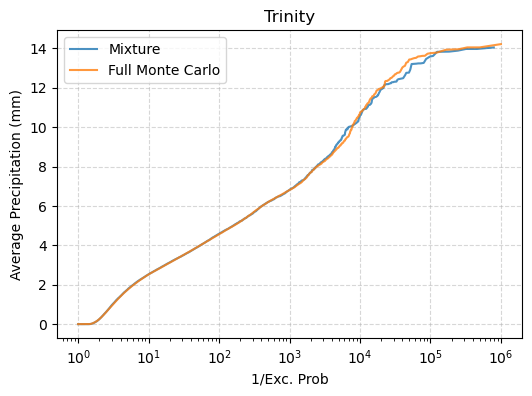

In [70]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(1/trinity_mixture_depths["exc_prb"], trinity_mixture_depths["precip_avg_mm"]/25.4, 
         label="Mixture", alpha=0.8)
plt.plot(1/trinity_fullmonte_depths["exc_prb"], trinity_fullmonte_depths["precip_avg_mm"]/25.4, 
         label="Full Monte Carlo", alpha=0.8)

plt.xscale("log")  # log scale for return period
plt.xlabel("1/Exc. Prob")
plt.ylabel("Average Precipitation (mm)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.title("Trinity")
plt.show()

In [71]:
get_error_stats(trinity_mixture_depths,trinity_fullmonte_depths,pcol="exc_prb", ycol="precip_avg_mm", to_inches=True)

{'rmse': 0.1374263083646515, 'diff_at_max': -0.16899500831493874}

Adaptive Mixture

In [7]:
params = AdaptParams(
    # Narrow component starts around watershed centroid
    mu_x_n=trinity.watershed_stats["x"],
    mu_y_n=trinity.watershed_stats["y"],
    sd_x_n=trinity.watershed_stats["range_x"]*0.5,
    sd_y_n=trinity.watershed_stats["range_y"]*0.5,

    # Wide component starts around full domain centroid
    mu_x_w=trinity.watershed_stats["x"],
    mu_y_w=trinity.watershed_stats["y"],
    sd_x_w=trinity.domain_stats["range_x"],
    sd_y_w=trinity.domain_stats["range_y"],

    # Optional extras
    mix=0.5,            # initial mixture weight for narrow
    rho_n=-0.7,         # correlation in narrow copula
    rho_w=0.5,          # correlation in wide copula
)

sampler = AdaptiveMixtureSampler(
    precip_cube=trinity.cumulative_precip,
    storm_centers=trinity.storm_centers,
    watershed_gdf=trinity.watershed_gdf,
    domain_gdf=trinity.domain_gdf,
    params=params,
    seed=42,
)

In [8]:
history = sampler.adapt(num_iterations=10, samples_per_iter=500)
print(history)

    iter       mix         mu_x_n        mu_y_n         sd_x_n         sd_y_n  \
0      0  0.500000  -47423.153148  1.019273e+06  196733.075237  222234.154816   
1      1  0.559148   70003.650294  9.971357e+05  265897.497335  184660.436507   
2      2  0.607803   87858.575381  9.686991e+05  272715.007215  177035.874783   
3      3  0.640394   70708.333185  9.748657e+05  257922.606155  173408.246587   
4      4  0.660395   71971.845123  9.680956e+05  262998.461225  175006.061765   
5      5  0.680523   91815.251084  9.918823e+05  258409.797224  162004.741475   
6      6  0.678865   93320.292355  9.779975e+05  265018.388241  171054.964098   
7      7  0.710843   98860.688473  9.809278e+05  283955.217853  176851.598572   
8      8  0.707769   84029.516113  9.733614e+05  284182.076564  178850.773409   
9      9  0.698858  128518.248260  9.818573e+05  285063.695767  163403.550250   
10    10  0.698750   92540.975263  9.743002e+05  282722.540181  187490.291955   

          mu_x_w        mu_

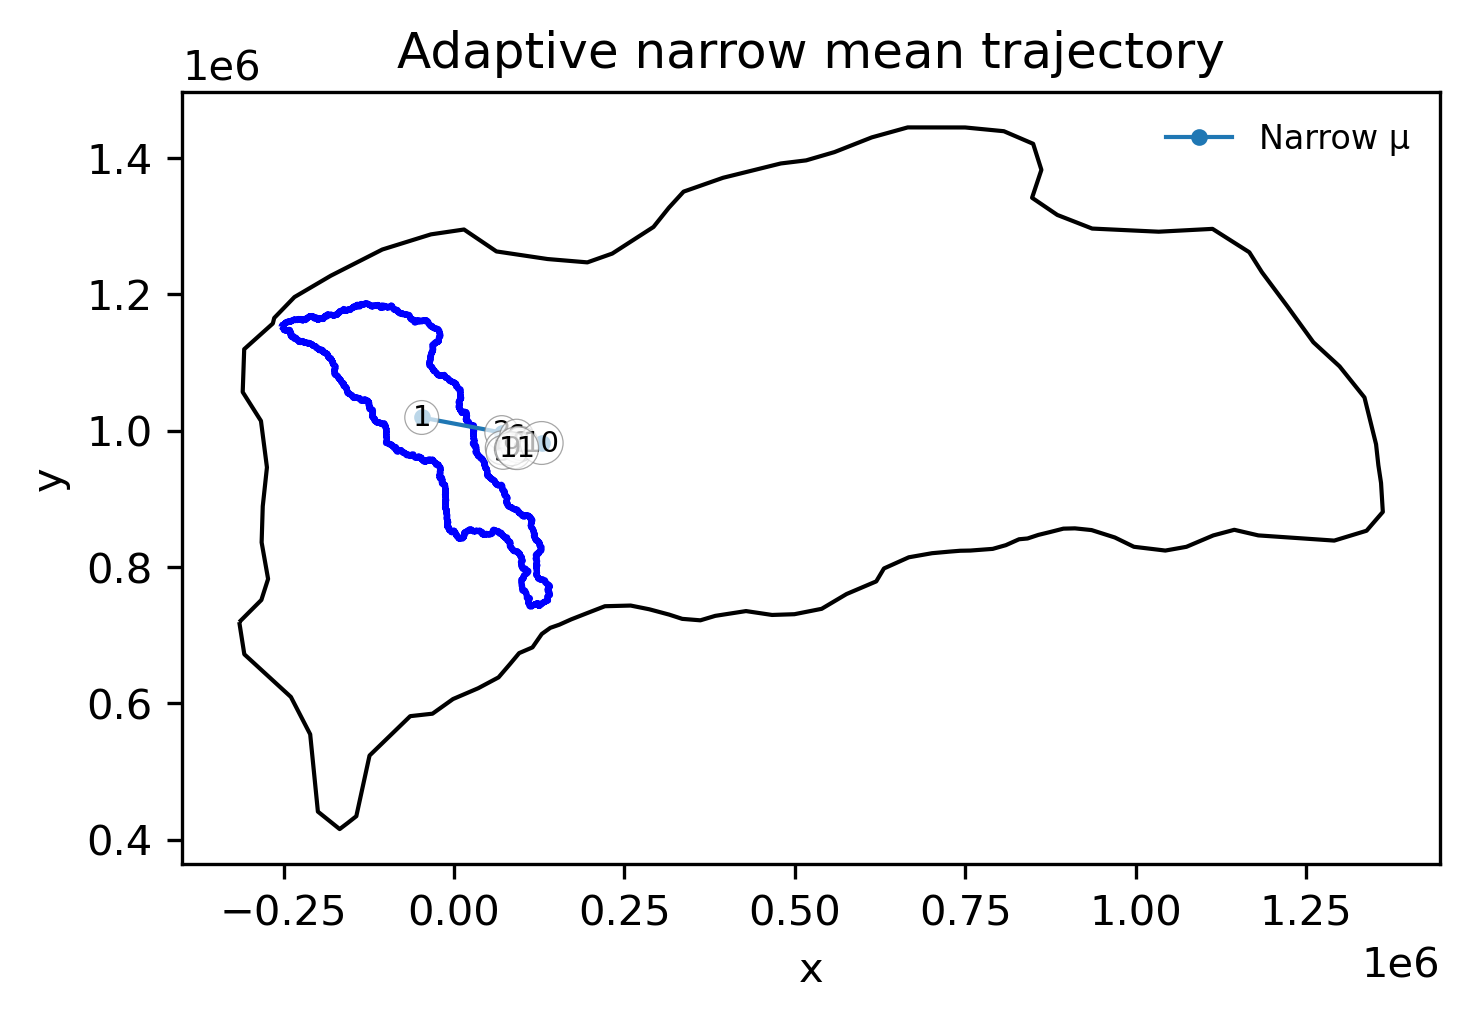

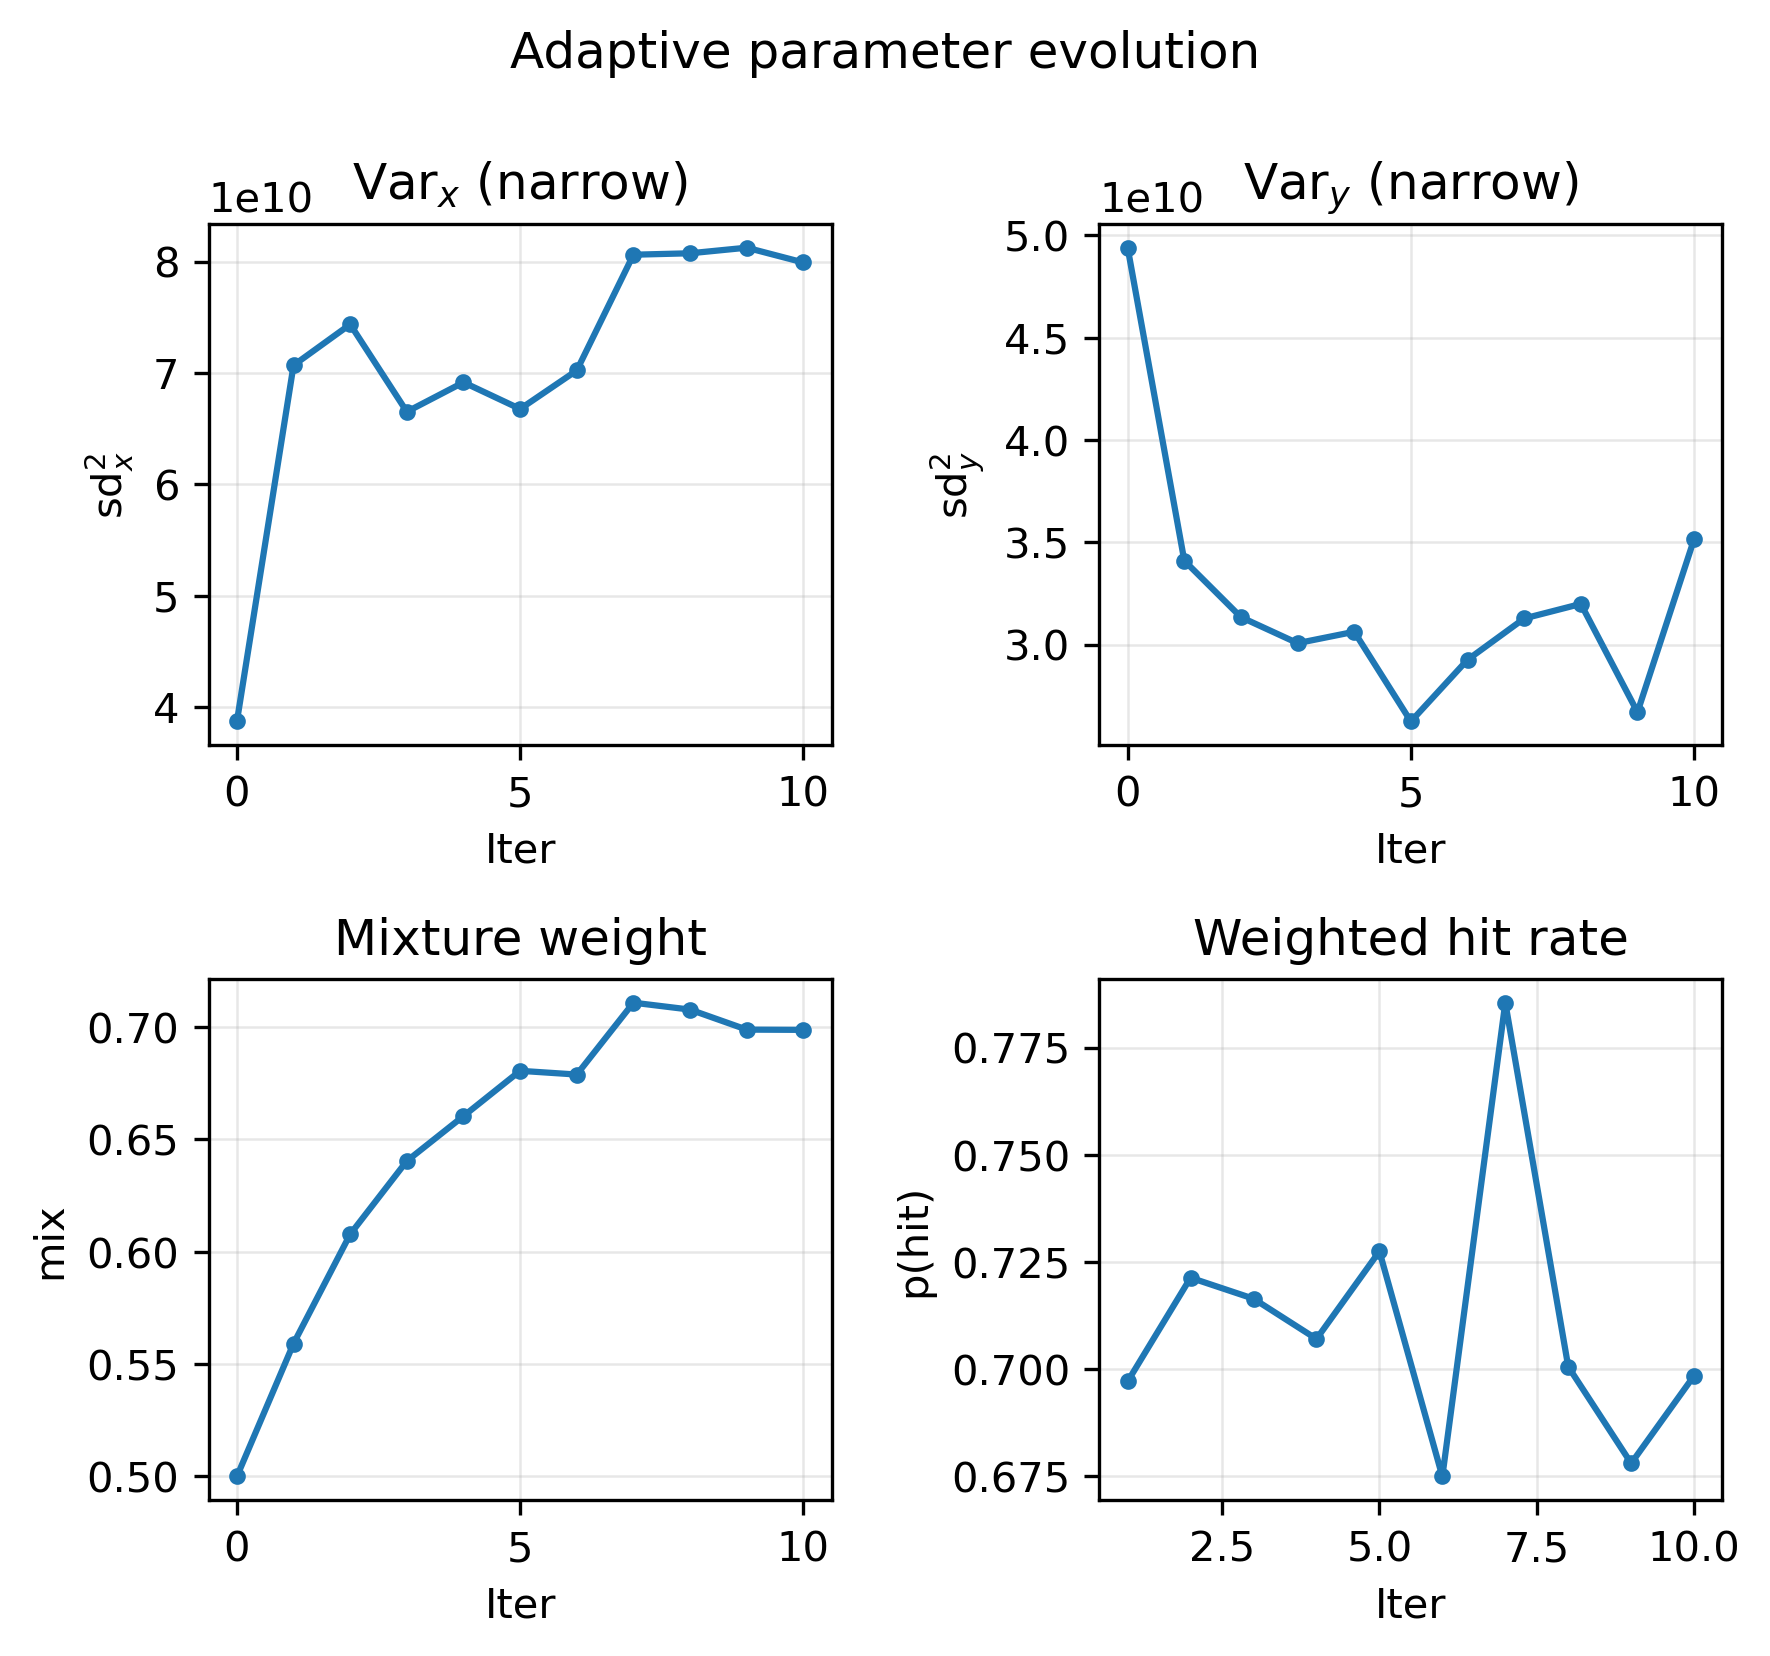

In [9]:
plot_adaptive_evolution(history, trinity.watershed_gdf, trinity.domain_gdf, save=False, prefix="trinity_ais")

In [ ]:
#Do final N required samples from the final distributions
samples = sampler.sample_final(n=100_000, with_depths=True)
print(samples.head()) 

   rep  event_id             x             y    weight  \
0    1     13743  20501.117607  1.073742e+06  0.000004   
1    1     86248  -8235.604187  1.111223e+06  0.000005   
2    1     95130  17465.809406  1.043403e+06  0.000004   
3    1      7391  45458.629748  1.065513e+06  0.000004   
4    1     98633  58054.549959  1.062658e+06  0.000004   

               storm_path  precip_avg_mm   exc_prb  
0  20170826_72hr_st2_r004     352.589081  0.000004  
1  20170826_72hr_st2_r004     341.278809  0.000010  
2  20170826_72hr_st2_r004     340.638184  0.000014  
3  20170826_72hr_st2_r004     335.401733  0.000018  
4  20170826_72hr_st2_r004     320.584595  0.000022  


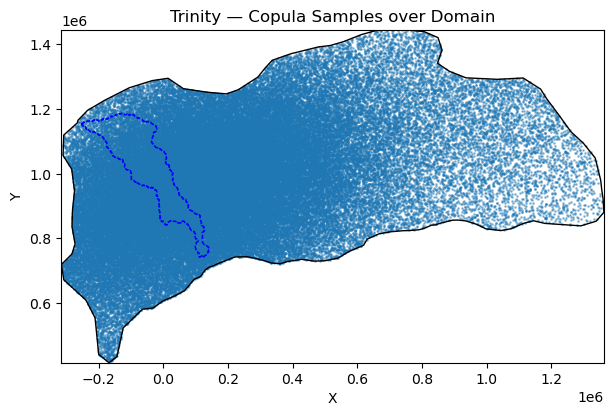

In [ ]:
import matplotlib.pyplot as plt

# Plot domain and watershed boundaries
fig, ax = plt.subplots(figsize=(7,7))
trinity.domain_gdf.boundary.plot(ax=ax, edgecolor="black", linewidth=1)
trinity.watershed_gdf.boundary.plot(ax=ax, edgecolor="blue", linewidth=1, linestyle="--")

# Scatter all samples (x, y)
ax.scatter(
    samples["x"].to_numpy(),
    samples["y"].to_numpy(),
    s=1, alpha=0.4
)

# Nice axes and title
ax.set_aspect("equal", adjustable="box")
minx, miny, maxx, maxy = trinity.domain_gdf.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_title("Trinity — Adaptive Mixture")
plt.show()

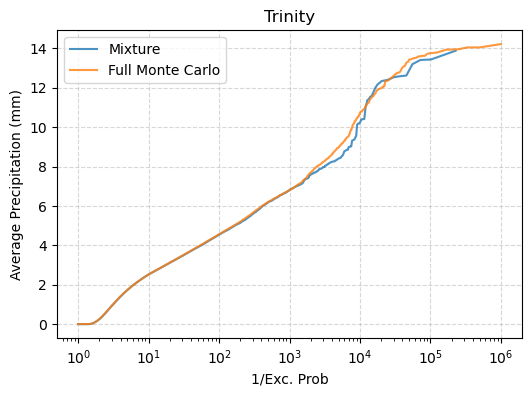

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(1/samples["exc_prb"], samples["precip_avg_mm"]/25.4, 
         label="Mixture", alpha=0.8)
plt.plot(1/trinity_fullmonte_depths["exc_prb"], trinity_fullmonte_depths["precip_avg_mm"]/25.4, 
         label="Full Monte Carlo", alpha=0.8)

plt.xscale("log")  # log scale for return period
plt.xlabel("1/Exc. Prob")
plt.ylabel("Average Precipitation (mm)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.title("Trinity")
plt.show()